In [2]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner
from astropy.stats import LombScargle


In [3]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e19-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [4]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.6 < b < 2.2:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [5]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [6]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.029667824877650056 1.9440762705301373


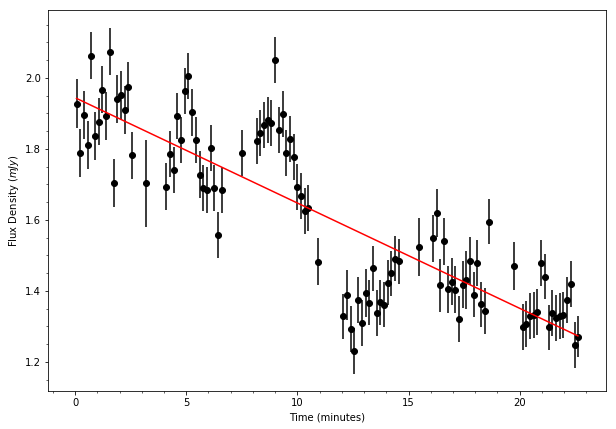

In [7]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel.png')
plt.show()

In [8]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.02929294,  1.94011174],
        [-0.03031162,  1.94558518],
        [-0.03001107,  1.95991419],
        [-0.02779673,  1.92246527],
        [-0.0302042 ,  1.96290473],
        [-0.02936601,  1.95552509],
        [-0.02865079,  1.93803402],
        [-0.02998875,  1.94927948],
        [-0.02933524,  1.9394574 ],
        [-0.03028423,  1.94594768],
        [-0.03048399,  1.95906688],
        [-0.03064367,  1.94786256],
        [-0.02875108,  1.93521743],
        [-0.02943229,  1.94810624],
        [-0.02893522,  1.9372835 ],
        [-0.0291881 ,  1.94787059],
        [-0.0286857 ,  1.93512859],
        [-0.02909661,  1.93982441],
        [-0.03138103,  1.9715058 ],
        [-0.03012244,  1.95713779],
        [-0.0306333 ,  1.95807481],
        [-0.02970235,  1.95321665],
        [-0.03067988,  1.94626481],
        [-0.02956258,  1.95178945],
        [-0.02938556,  1.93947668],
        [-0.02811606,  1.93073446],
        [-0.02814403,  1.92393746],
        [-0.03079978,  1.967

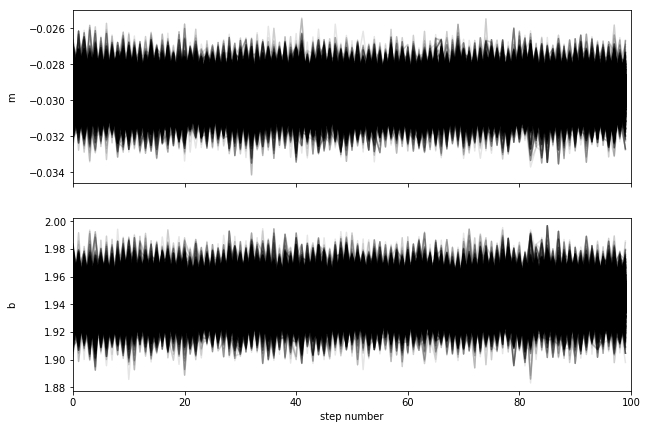

In [9]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_linearTrace.png')
plt.show()

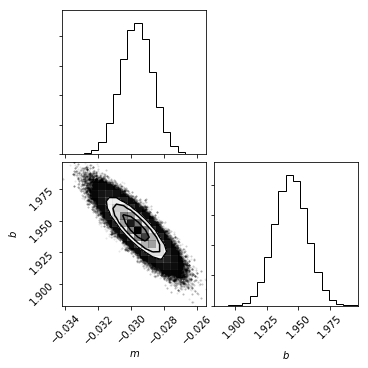

In [10]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e19_linearCorner.png')
plt.show()

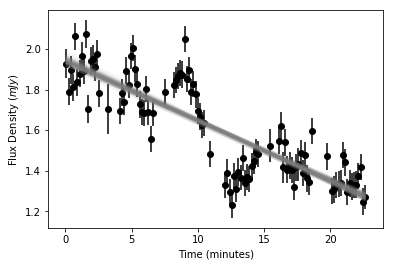

In [11]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_data.png')
plt.show()

In [12]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

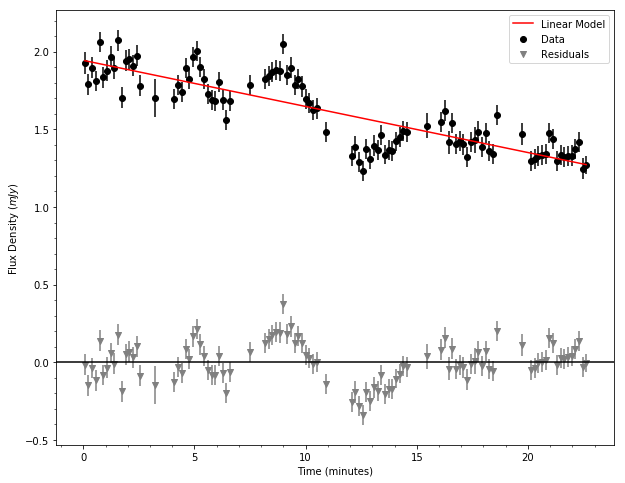

In [13]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,8))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel_fit.png')
plt.show()

In [14]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(x)-2)

3.825662423410944

## Fitting an logistic function


In [15]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 0 and -5 < k < 10 and 9 < x0 < 15 and 1.6 < y0 < 2.0:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [16]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.4528223066730901 3.1683989202336402 10.39846579331271 1.8441010944872955


In [17]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.45849017,  3.57696123, 10.34329504,  1.8507186 ],
        [-0.48093808,  3.96511851, 10.31686493,  1.87406284],
        [-0.44990404,  5.32291182, 10.46152271,  1.84169809],
        [-0.45994117,  4.85960706, 10.35079211,  1.85211567],
        [-0.45362874,  3.12531333, 10.32691913,  1.8429325 ],
        [-0.47567528,  4.70732084, 10.27846628,  1.86492677],
        [-0.43651722,  3.47001616, 10.53639409,  1.83342535],
        [-0.46738262,  5.8215303 , 10.46372255,  1.84910663],
        [-0.44018673,  2.73256386, 10.42470342,  1.83845497],
        [-0.43116566,  3.3291187 , 10.49581256,  1.83299642],
        [-0.46831056,  4.04105348, 10.33520218,  1.85795021],
        [-0.46864726,  2.77719077, 10.49493371,  1.84668194],
        [-0.45741732,  2.50598853, 10.46839915,  1.85646605],
        [-0.45454094,  4.38279222, 10.28007495,  1.8417661 ],
        [-0.4496314 ,  3.77354693, 10.37719537,  1.84021696],
        [-0.44252998,  4.51646738, 10.25316518,  1.85607274],
        

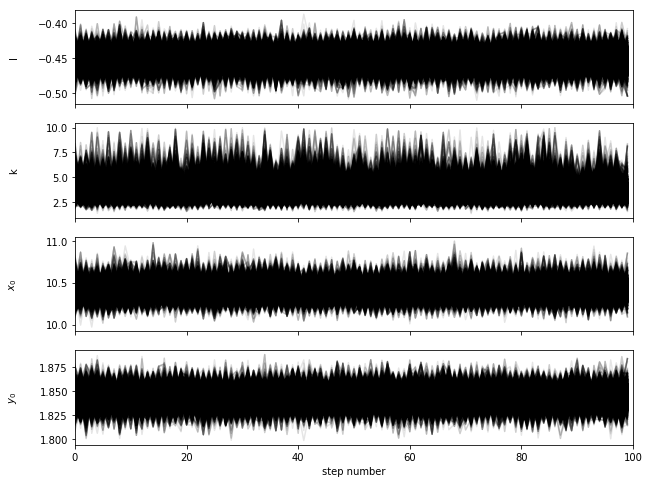

In [18]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,8),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_Trace.png')
plt.show()

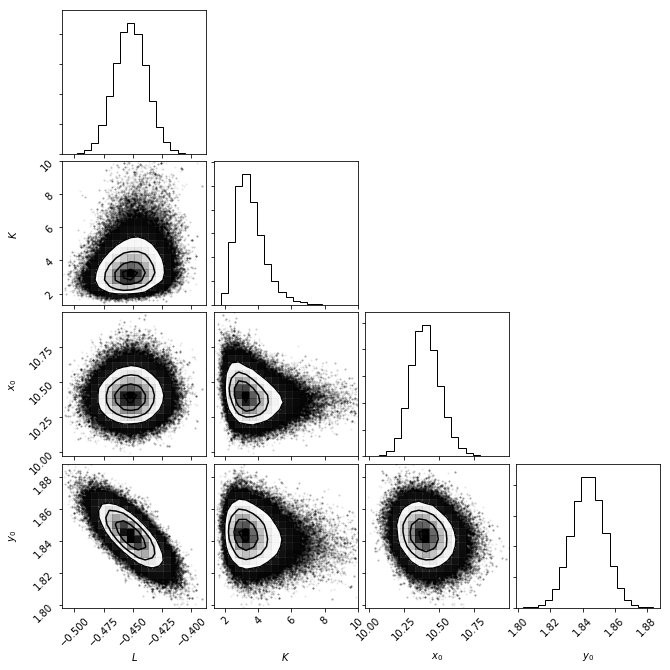

In [19]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/1314e19_logCorner.png')
plt.show()

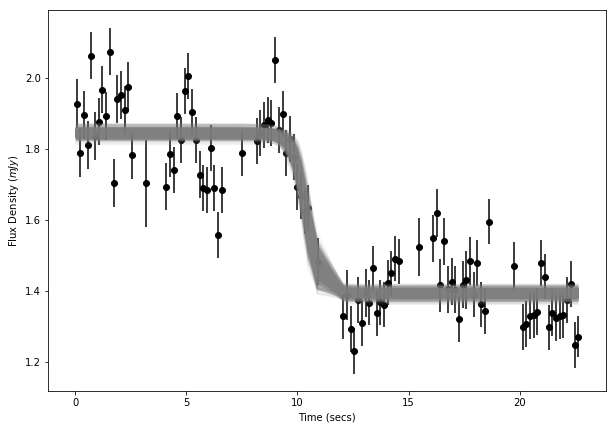

In [20]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_log.png')
plt.show()

In [21]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

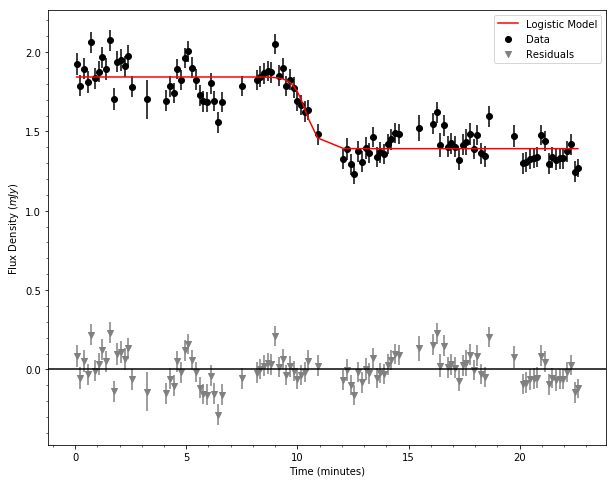

In [22]:
# -0.45148,3.39156,10.39780,1.84333

# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(10,8))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/1314e19_logModel.png')
plt.show()

In [23]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(x)-4)

2.2195152550985253

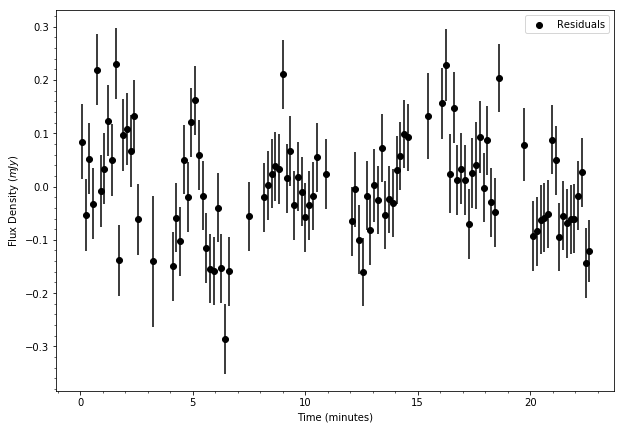

In [24]:
plt.figure(figsize=(10,7))
plt.scatter(x,logResid,color='black',marker='o',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='black',label='_nolegend_',linestyle='None')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.show()

## e19 Looking at Stokes I, V and circular polarization

In [25]:
rr = pd.read_table('1314/2M1314e19-RR.dat')
ll = pd.read_table('1314/2M1314e19-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)

In [26]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

In [27]:
data = pd.DataFrame(data={'time':time,'stI':stI,'stErr':stErr})
data.to_csv('stokesI.csv')

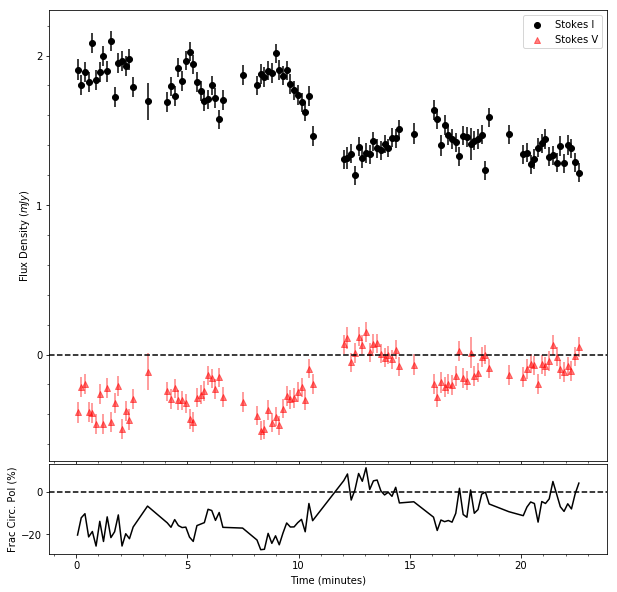

In [28]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':0.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='--')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.savefig('plots/1314e19_stokes.png')
plt.show()

100


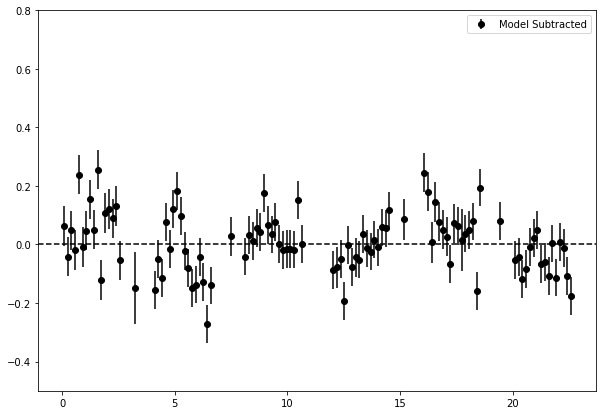

In [29]:
log_model = logModel([-0.45148,3.39156,10.39780,1.84333],x)

modelSub = stI - log_model
print(len(modelSub))

plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',marker='o',label='Model Subtracted')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

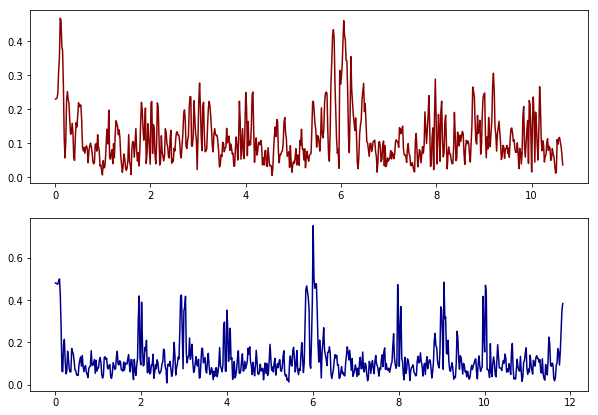

NameError: name 'lomb' is not defined

In [30]:
# On-state
freq1, power1 = LombScargle(time[:50],modelSub[:50],stErr[:50],nterms=3).autopower()

# Quiesent 
freq2, power2 = LombScargle(time[50:],modelSub[50:],stErr[50:],nterms=3).autopower()

# Plotting the freq vs power
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,7))
ax[0].plot(freq1,power1,color='darkred')
ax[1].plot(freq2,power2,color='darkblue')
plt.show()

# Making pandas table of the values
lomb1 = pd.DataFrame(data={'freq':freq1,'power':power1,'time':1/freq1*60})
lomb1 = lomb.sort_values('power',ascending=False)

lomb2 = pd.DataFrame(data={'freq':freq2,'power':power2,'time':1/freq2*60})
lomb2 = lomb.sort_values('power',ascending=False)

# Making models
best_freq1 = lomb1['freq'].iloc[1]
x_fit1 = np.linspace(np.min(time[:50]),np.max(time[:50]))
y_fit1 = LombScargle(time[:50],modelSub[:50],stErr[:50],nterms=3).model(x_fit1,best_freq1)

best_freq2 = lomb2['freq'].iloc[1]
x_fit2 = np.linspace(np.min(time[50:]),np.max(time[50:]))
y_fit2 = LombScargle(time[50:],modelSub[50:],stErr[50:],nterms=3).model(x_fit2,best_freq2)

plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,color='black',yerr=stErr,marker='o',linestyle='None')
plt.plot(x_fit1,y_fit1,color='darkred',label='On State')
plt.plot(x_fit2,y_fit2,color='darkblue',label='Off State')
plt.show()

print(1/best_freq1,1/best_freq2)


In [ ]:
# The whole thing
freq, power = LombScargle(time,modelSub,stErr,nterms=3).autopower()

# Plotting the freq vs power
plt.figure(figsize=(10,7))
plt.plot(freq1,power1,color='darkred')

# Making pandas table of the values
lomb = pd.DataFrame(data={'freq':freq,'power':power,'time':1/freq*60})
lomb = lomb.sort_values('power',ascending=False)

# Making models
best_freq = lomb['freq'].iloc[0]
x_fit = np.linspace(np.min(time),np.max(time))
y_fit = LombScargle(time,modelSub,stErr,nterms=3).model(x_fit,best_freq)

# plotting data and model
plt.figure(figsize=(10,7))
plt.errorbar(time,modelSub,color='black',yerr=stErr,marker='o',linestyle='None')
plt.plot(x_fit,y_fit,color='darkred')
plt.show()

print(1/best_freq)



In [31]:
high = pd.read_table('1314/2M1314e19-7GHz.dat')
low = pd.read_table('1314/2M1314e19-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10,2)
low = binning(low,10,2)


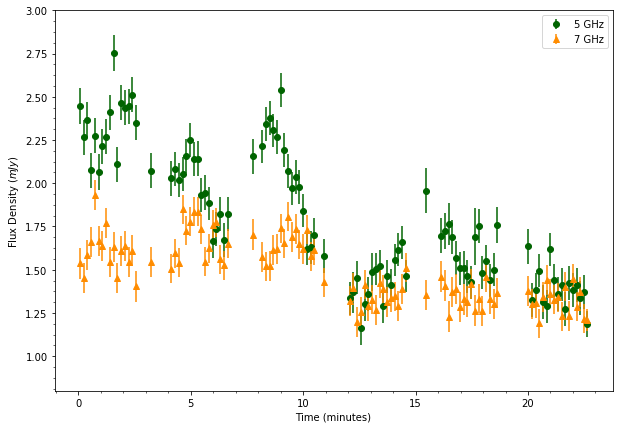

In [32]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',color='darkgreen',linestyle='None',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='^',color='darkorange',linestyle='None',label='7 GHz')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.ylim(0.8,3)
plt.minorticks_on()

plt.savefig('plots/1314_e19_SED.png')
plt.show()

In [ ]:
LombScargle()